In [48]:
import argparse
import collections
import functools
import json
import imageio
import os
import pathlib
import sys
import time
from PIL import Image
import skvideo.io
import matplotlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MUJOCO_GL'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as prec
from blox.utils import AverageMeter, timing
from blox.basic_types import map_dict
import time
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from tensorflow_probability import distributions as tfd

# sys.path.append(str(pathlib.Path(__file__).parent))

import models
import tools
import wrappers
from dreamer import Dreamer, preprocess, make_bare_env
import dreamer
import gn_solver
import gn_solver_goal
from utils import logging
from dreamer_colloc import DreamerColloc, make_env
import dreamer_colloc

def define_config():
  config = dreamer_colloc.define_config()

  return config

def fig2img(fig):
    """Converts a given figure handle to a 3-channel numpy image array."""
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    buf = np.roll(buf, 3, axis=2)
    w, h, d = buf.shape
    return np.array(Image.frombytes("RGBA", (w, h), buf.tostring()))[:, :, :3]

In [2]:
# Parse arguments
try:
    import colored_traceback
    colored_traceback.add_hook()
except ImportError:
    pass
parser = argparse.ArgumentParser()
for key, value in define_config().items():
    parser.add_argument(f'--{key}', type=tools.args_type(value), default=value)
args = '--logdir ./logdir/pm_obstacle/far_goal_b01_sr/offline --task colloc_pm_obstacle --action_repeat 1 --time_limit 40 --planning_task colloc_second_order --batch_length 30 --planning_horizon 40 --mpc_steps 40 --gd_steps 200 --logdir_colloc ./logdir/pm_obstacle/far_goal_b01_sr/09_29_denseoffline_40x1_colloc_rw1_dt1e-6_at1e-6_norm1_gd200_-0.4_0_2 --rew_res_wt 1 --dyn_threshold 1e-6 --act_threshold 1e-6 --coeff_normalization 1 --eval_tasks 1 --state_regressor=True'
config = parser.parse_args(args.split(' '))

In [9]:
# Build env and agent
if config.gpu_growth:
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
assert config.precision in (16, 32), config.precision
if config.precision == 16:
    prec.set_policy(prec.Policy('mixed_float16'))
config.steps = int(config.steps)
config.logdir.mkdir(parents=True, exist_ok=True)
print('Logdir', config.logdir)
config.logdir_colloc.mkdir(parents=True, exist_ok=True)

# Create environment.
env = make_env(config)

# Create agent.
actspace = env.action_space
datadir = config.logdir / 'episodes'
agent = DreamerColloc(config, datadir, actspace)
agent.load(config.logdir / 'variables.pkl')


Logdir logdir/pm_obstacle/far_goal_b01_sr/offline
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']


/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Found 5550424 model parameters.
Found 575204 actor parameters.
Found 413601 value parameters.


In [12]:
# Visualize

""" Run planning loop """
# Define task-related variables
assert config.planning_task == 'colloc_second_order'
actspace = env.action_space
obs = env.reset()
obs['image'] = [obs['image']]
# Obtain goal observation for goal-based collocation
is_goal_based = 'goal' in config.planning_task or config.goal_based
if is_goal_based:
    goal_obs = env.render_goal()
    imageio.imwrite('goal_img.jpg', goal_obs['image'])
    goal_obs['image'] = [goal_obs['image']]
else:
    goal_obs = None

Final average dynamics loss: 8.9236812073068e-07
Final average action violation: 3.635883274455409e-07
Final total reward: -21.68379020690918
Final average initial state violation: 1.9759282751663498e-11


In [ ]:
act_pred, img_pred, feat_pred, info = agent.collocation_so(obs, goal_obs, True, 0)
plans = info['plans']
# agent.logger.log_video(f"plan/0", img_pred.numpy())

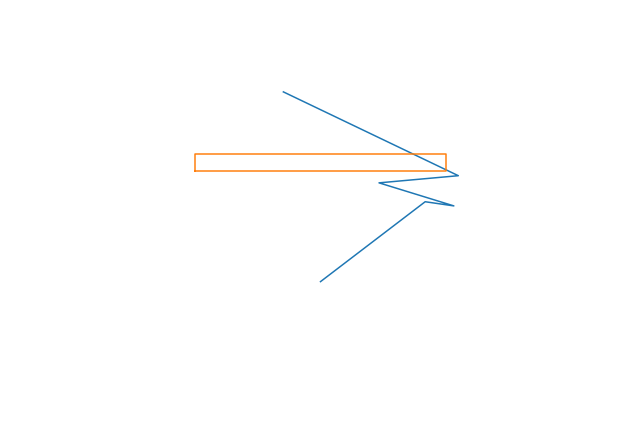

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


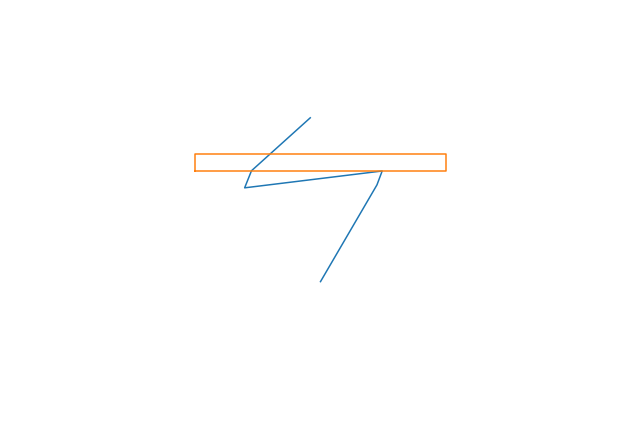

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


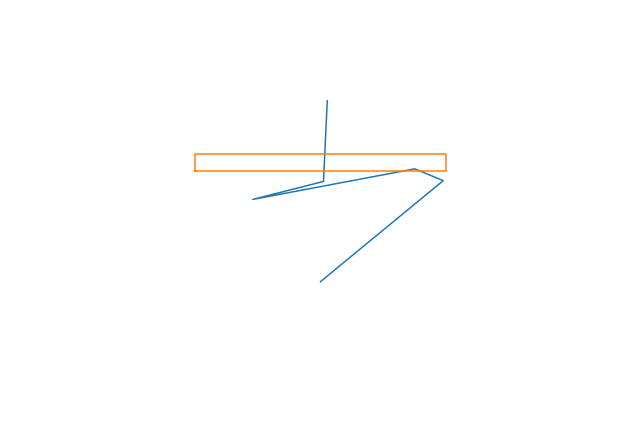

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


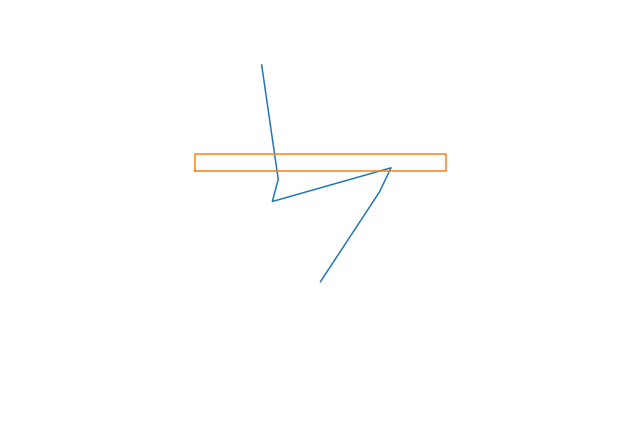

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


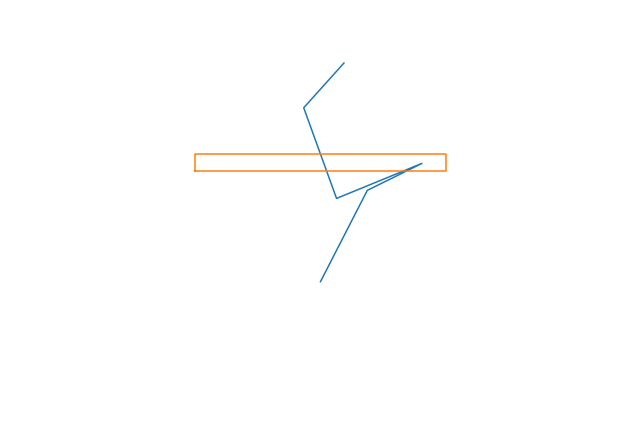

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


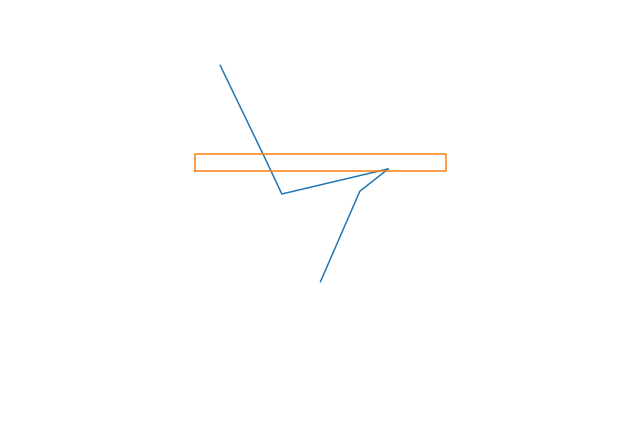

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


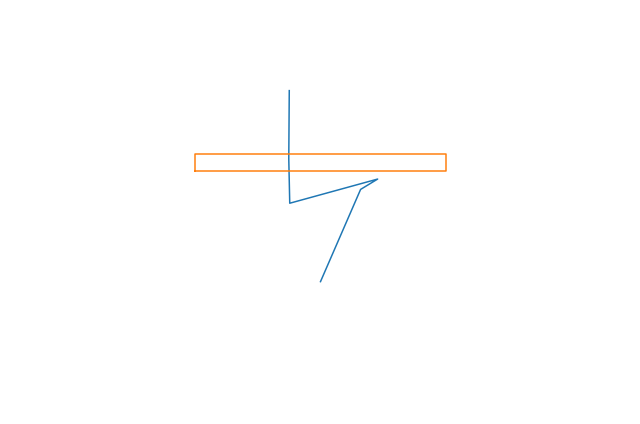

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


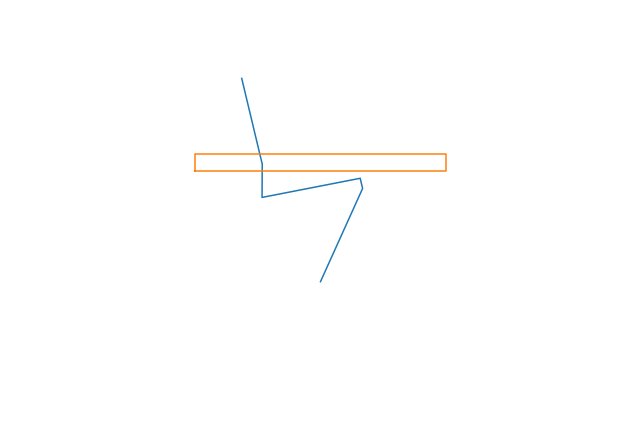

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


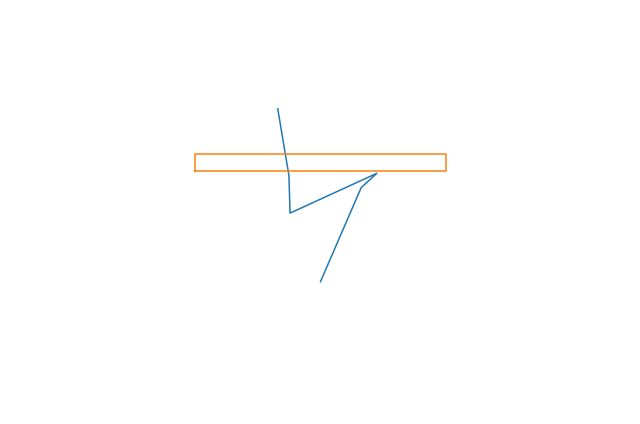

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


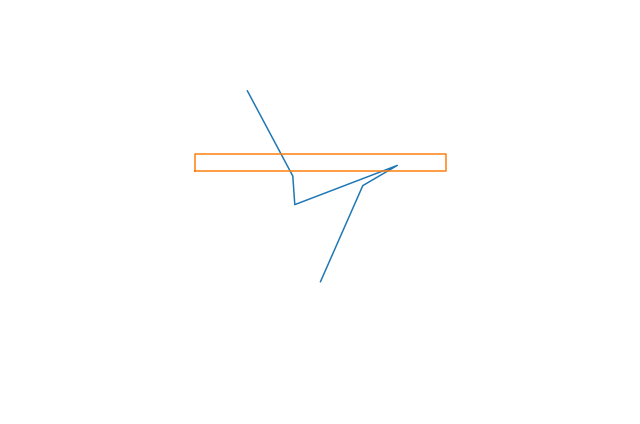

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


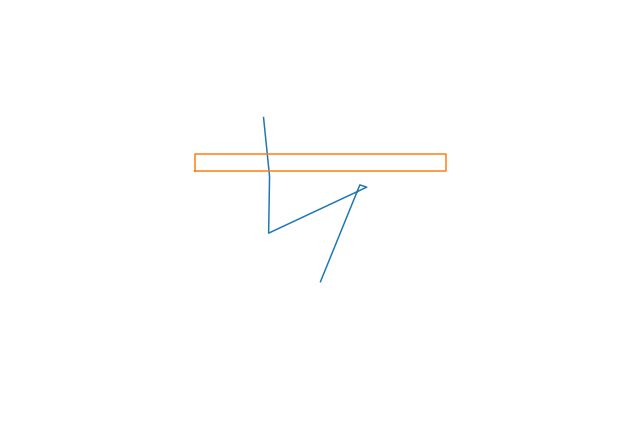

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


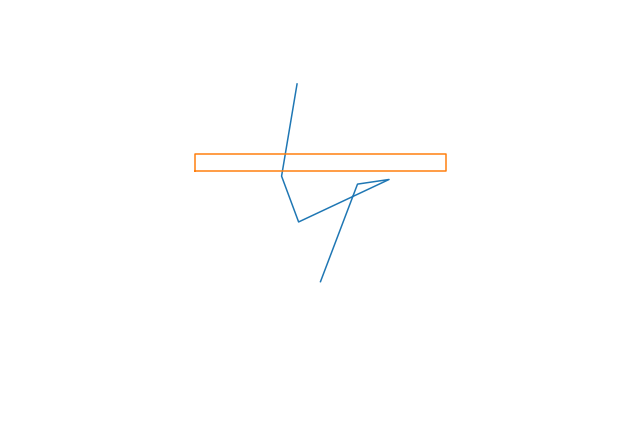

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


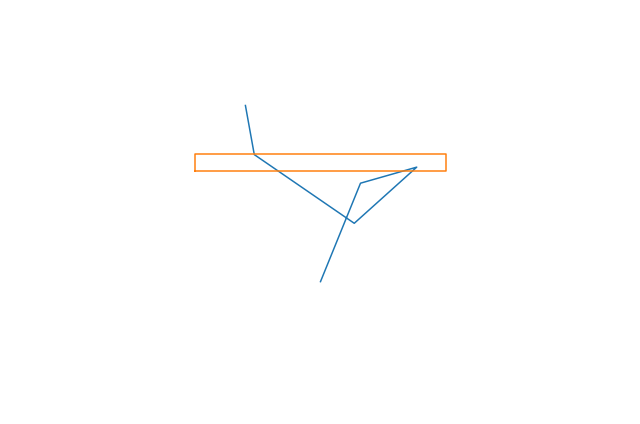

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


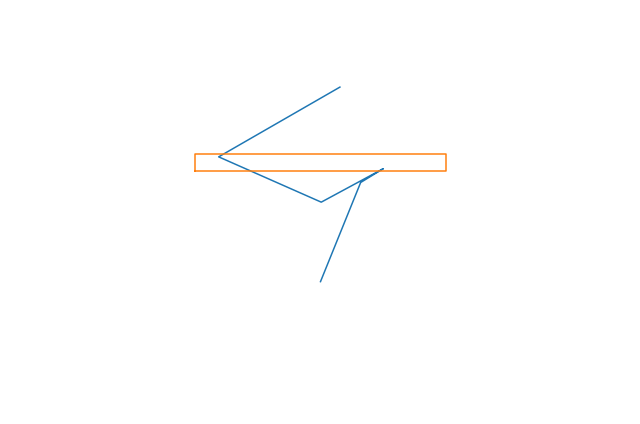

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


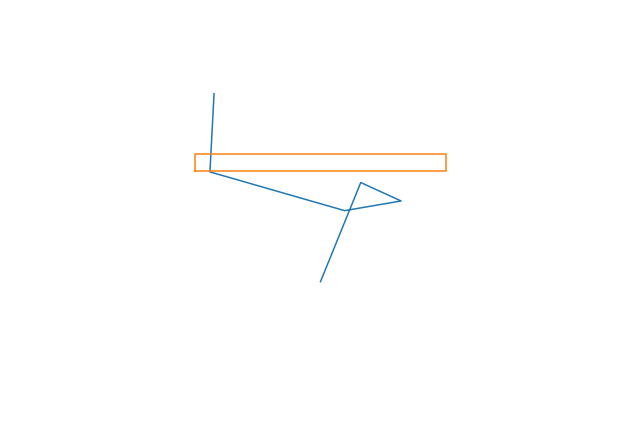

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


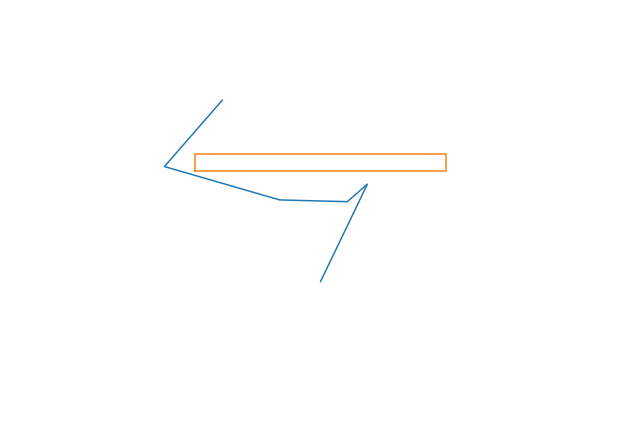

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


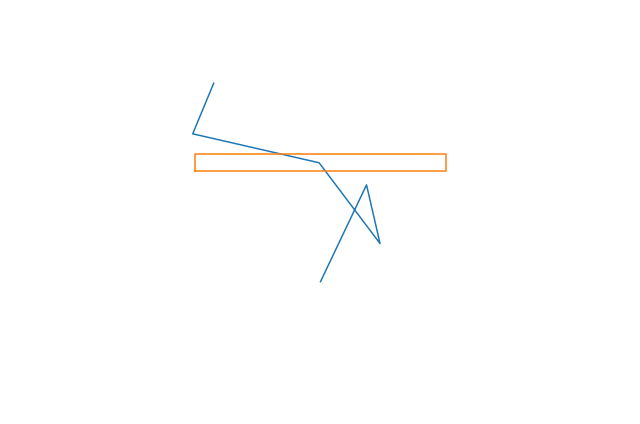

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


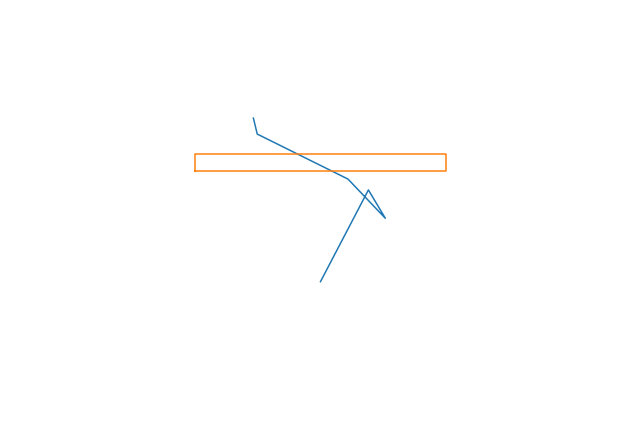

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


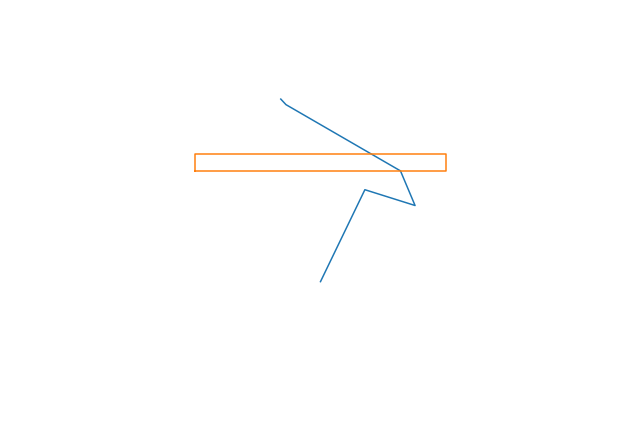

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


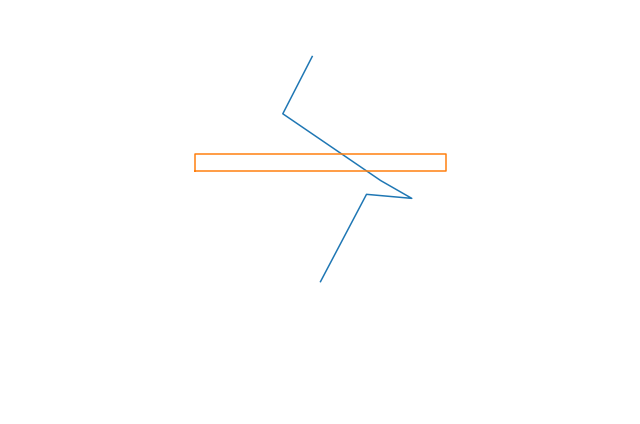

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


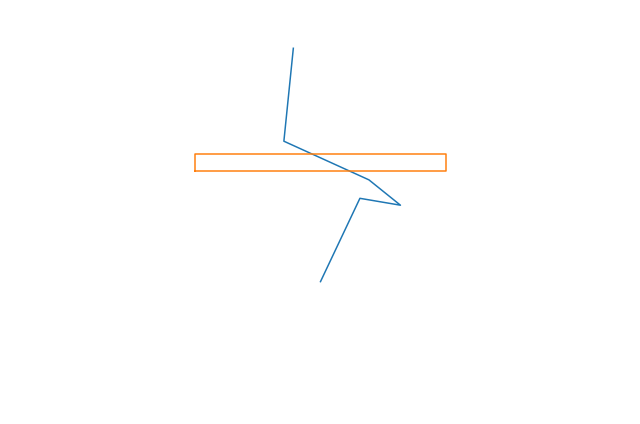

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


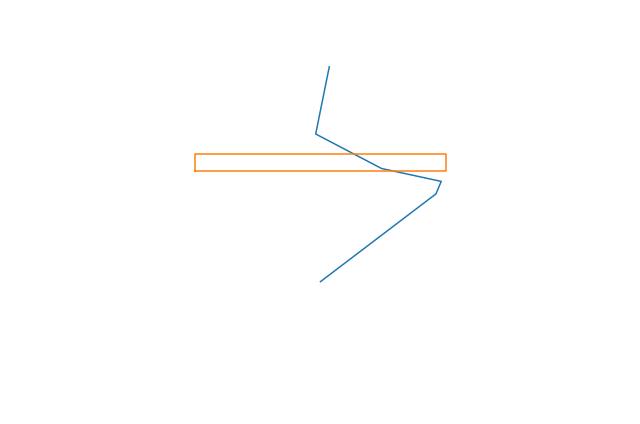

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


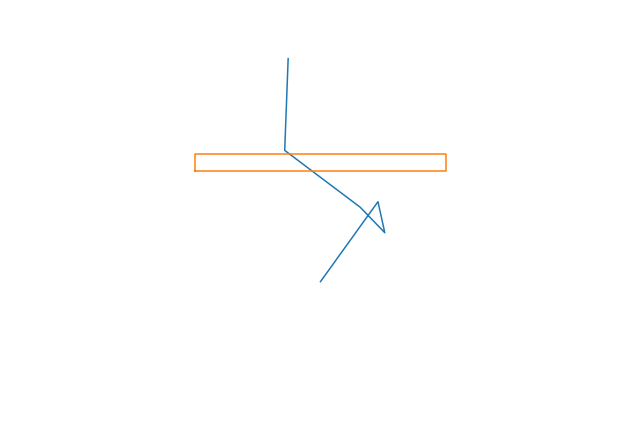

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


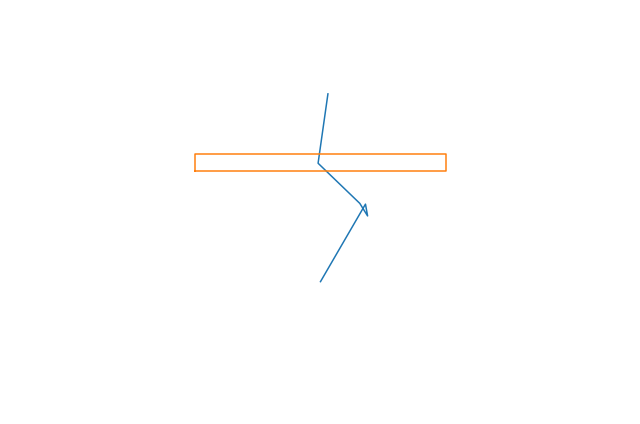

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


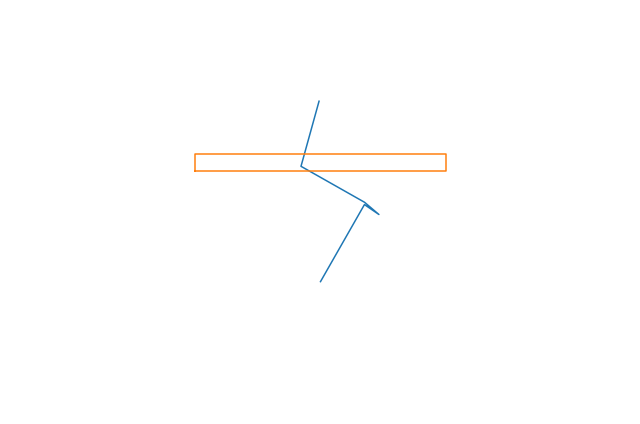

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


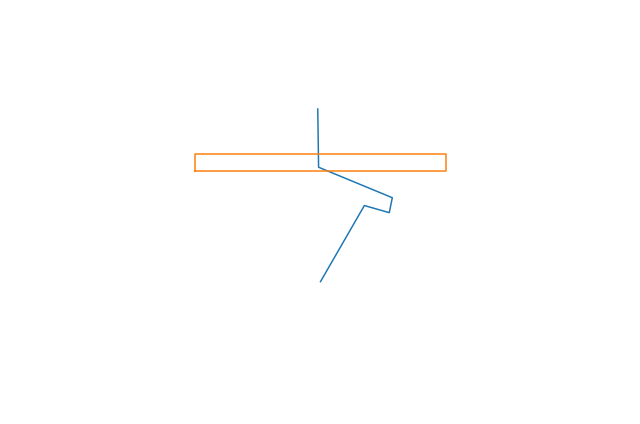

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


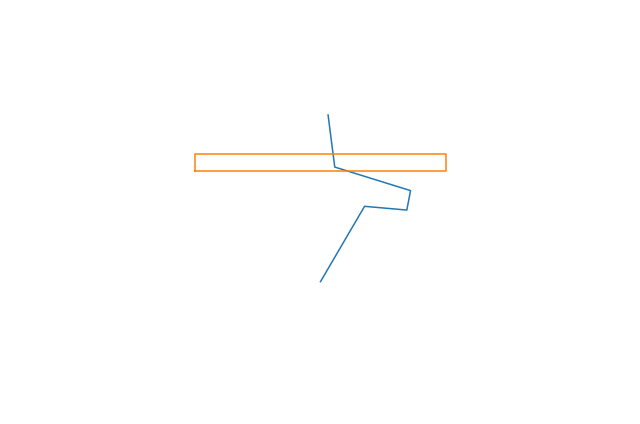

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


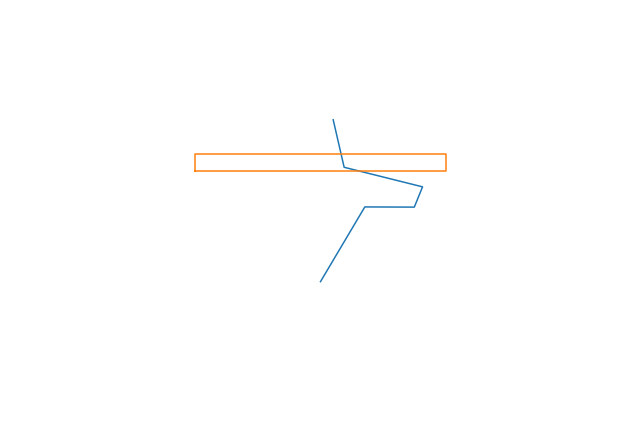

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


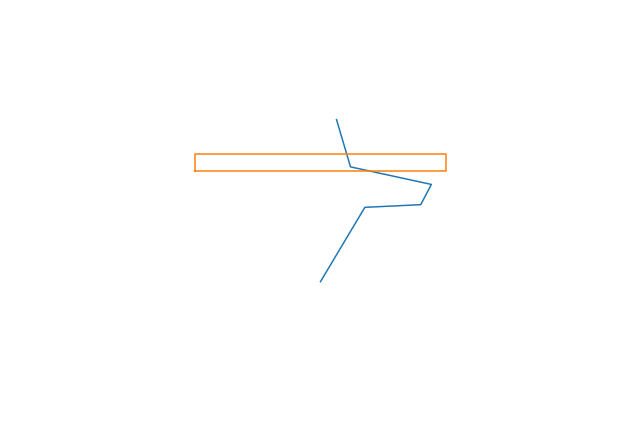

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


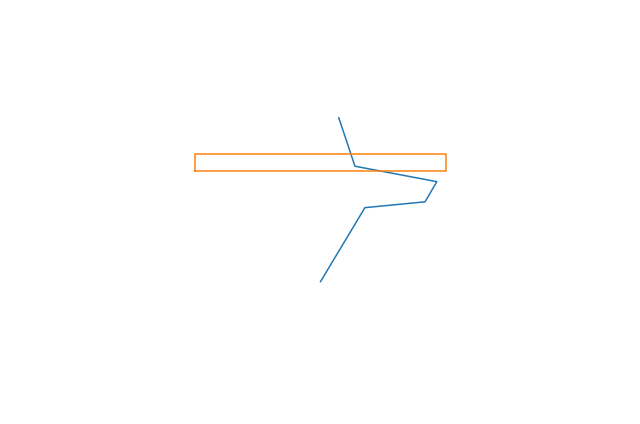

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


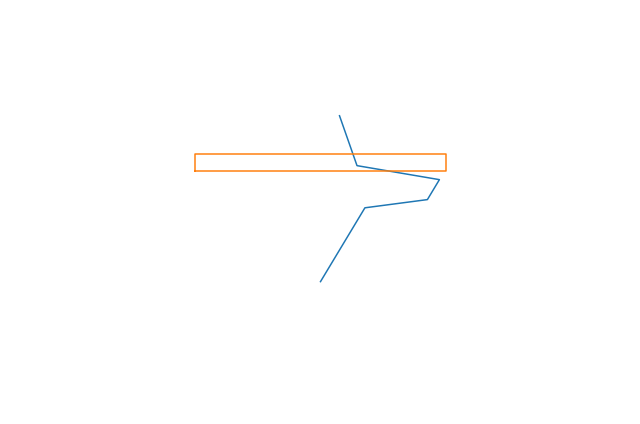

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


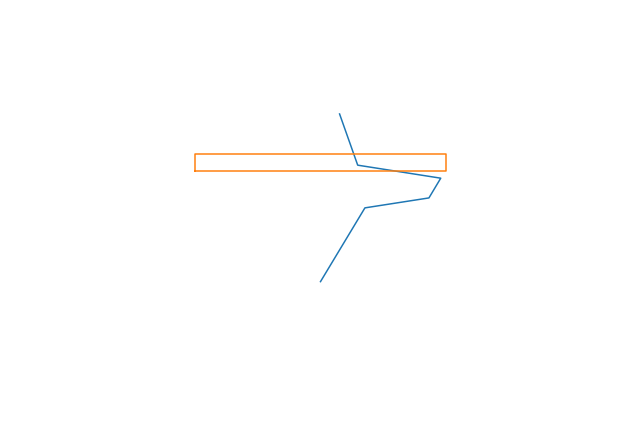

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


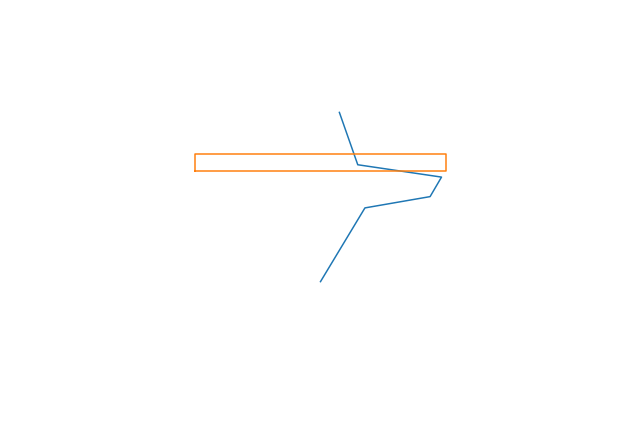

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


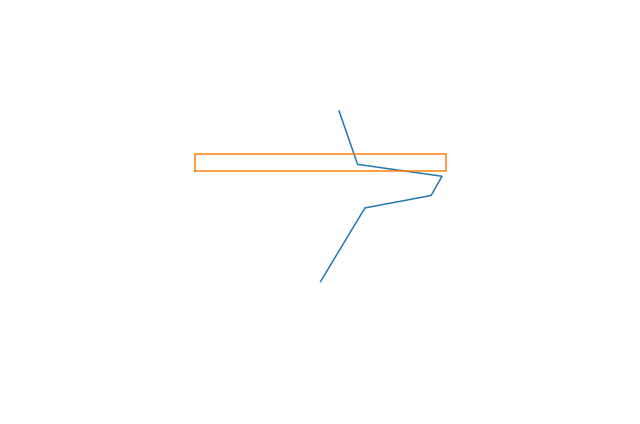

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


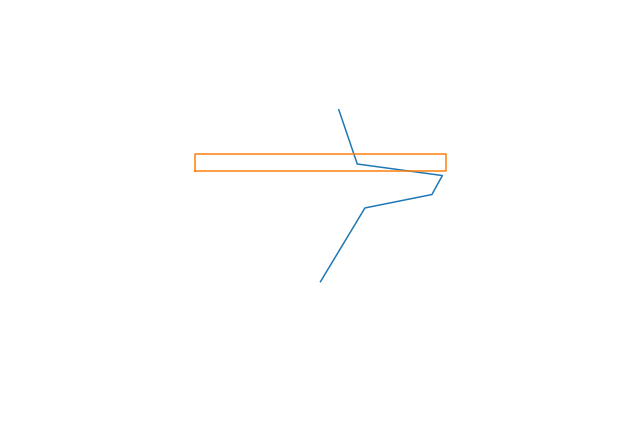

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


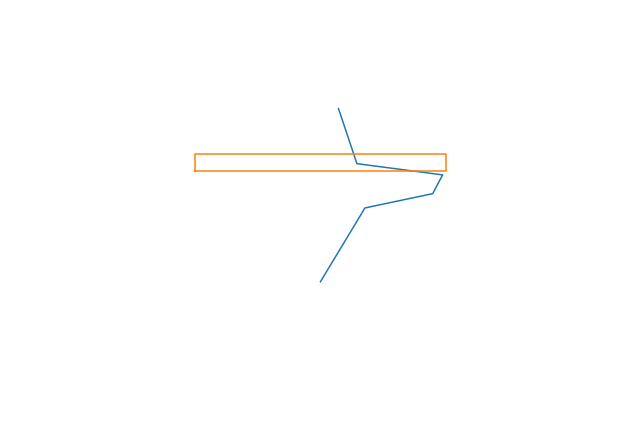

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


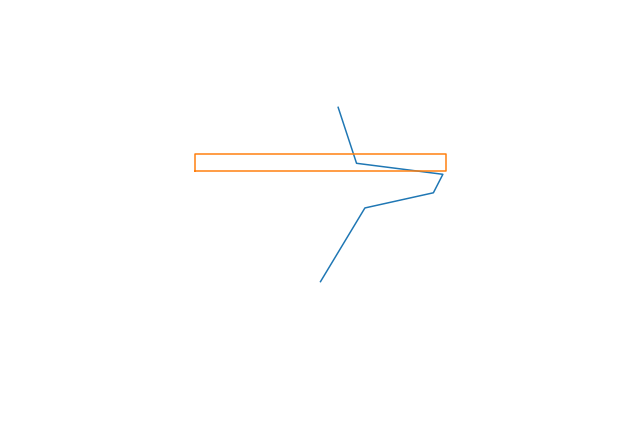

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


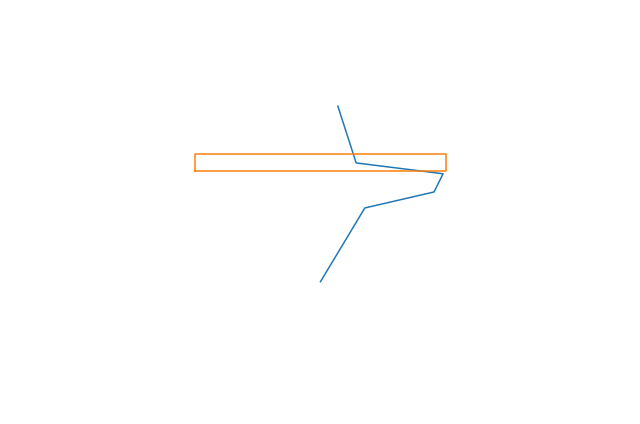

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


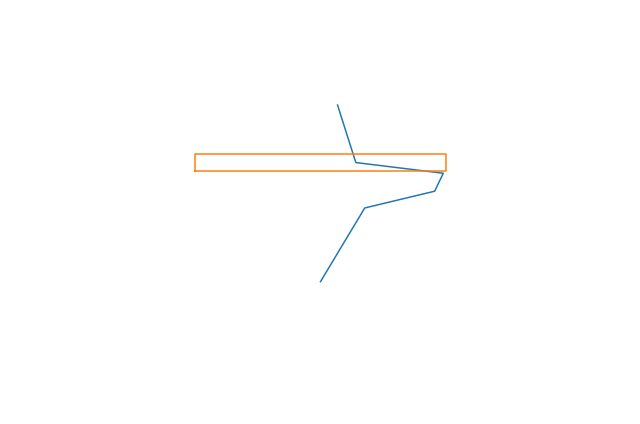

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


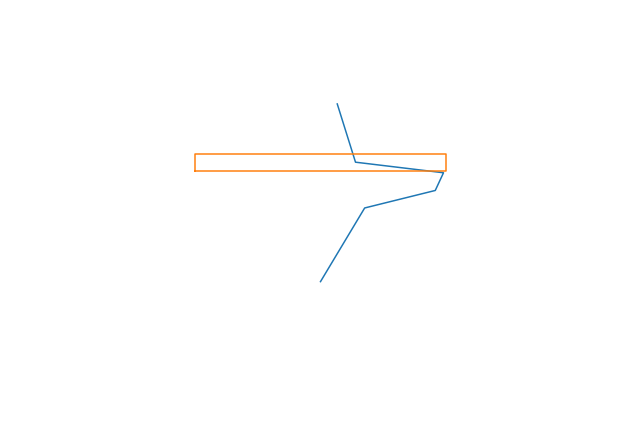

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


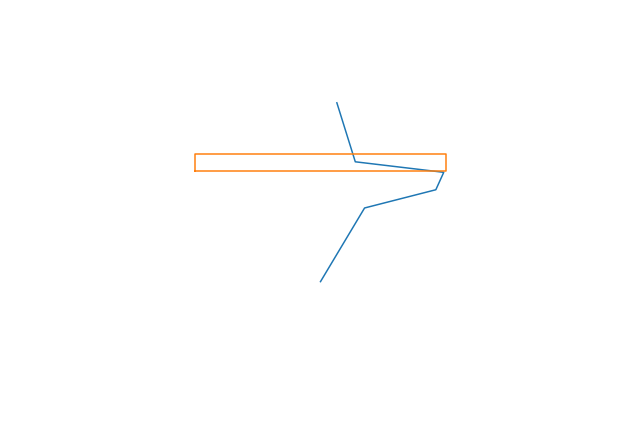

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


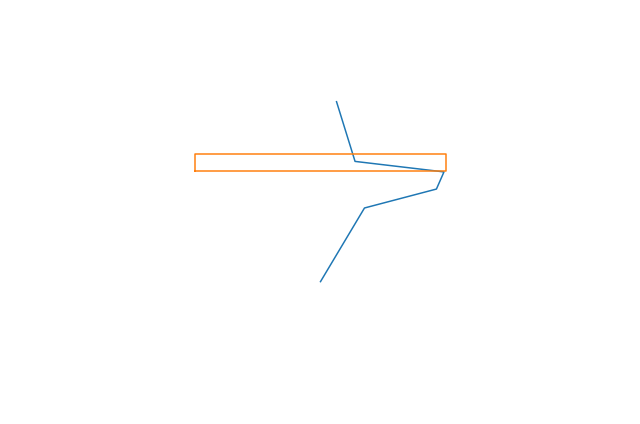

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


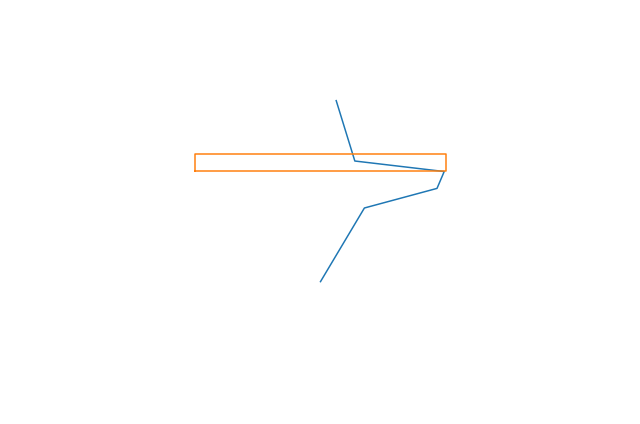

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


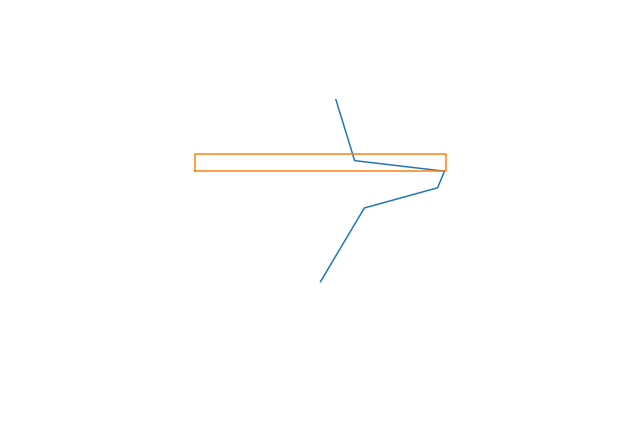

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


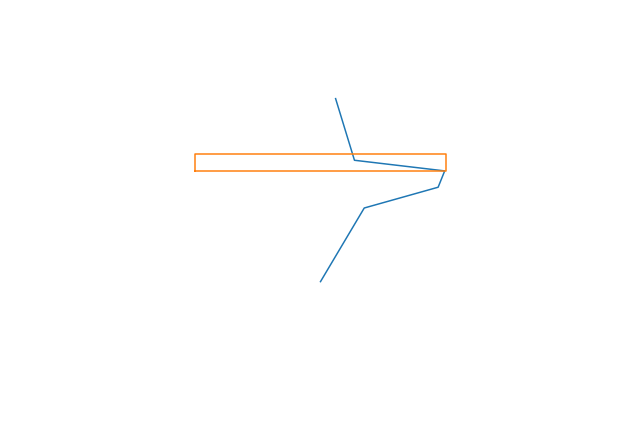

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


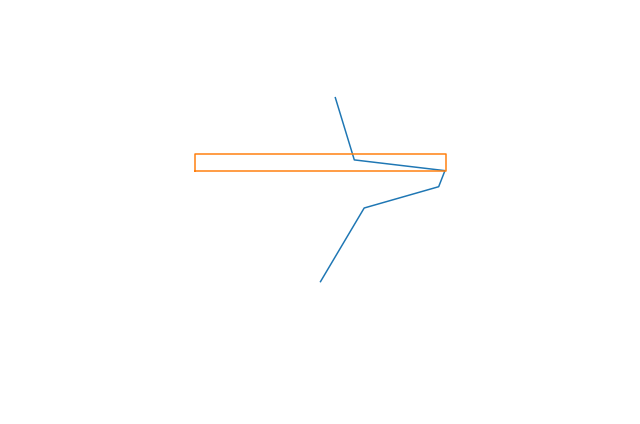

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


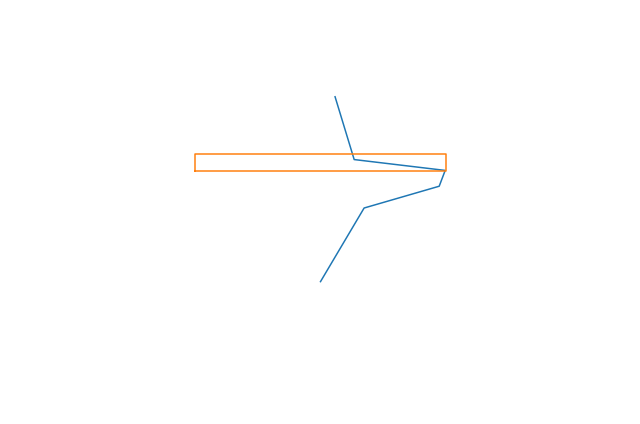

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


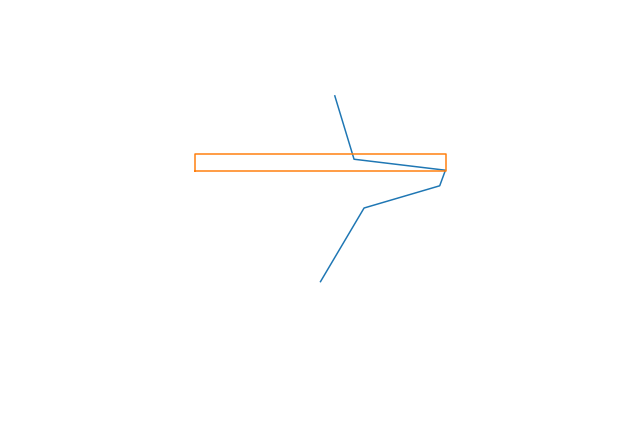

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


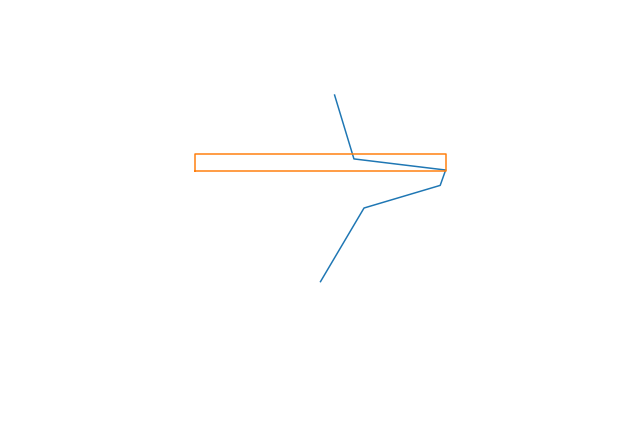

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


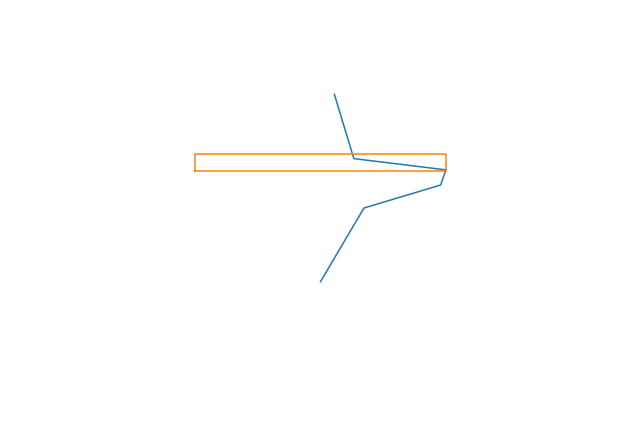

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


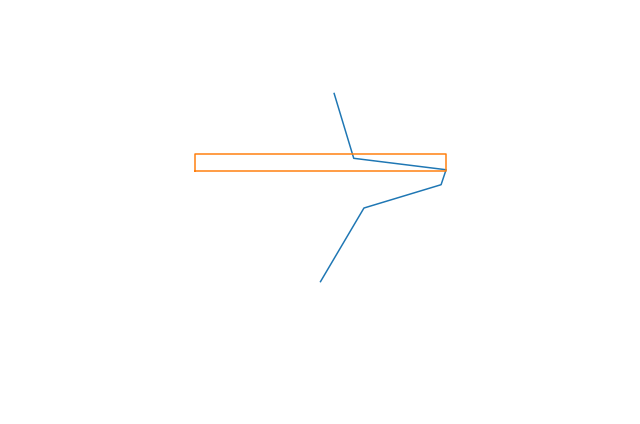

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


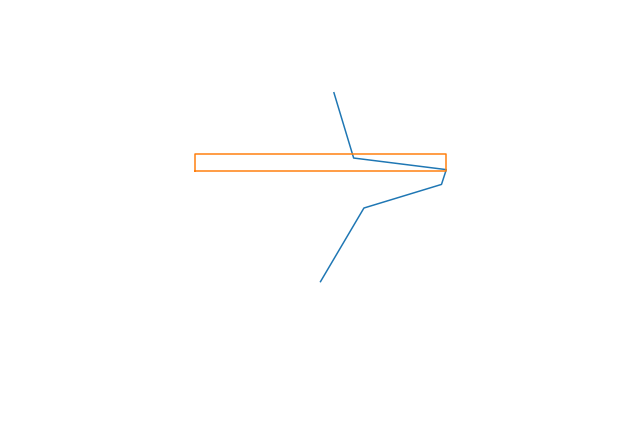

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


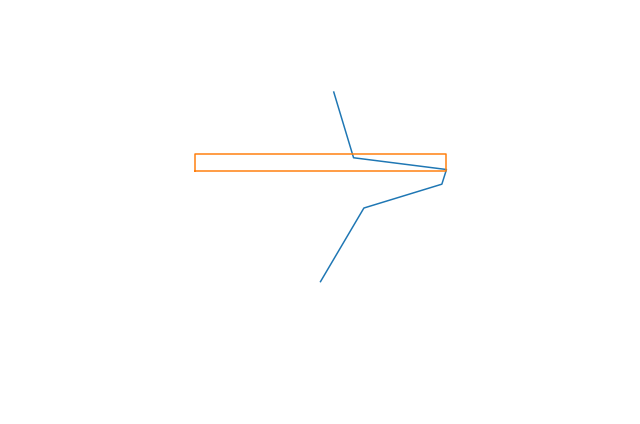

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


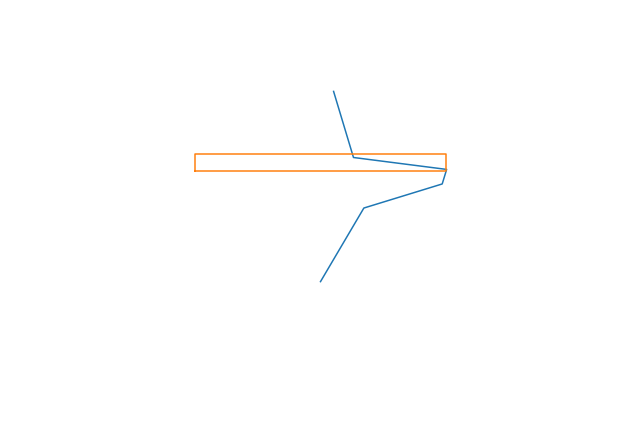

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


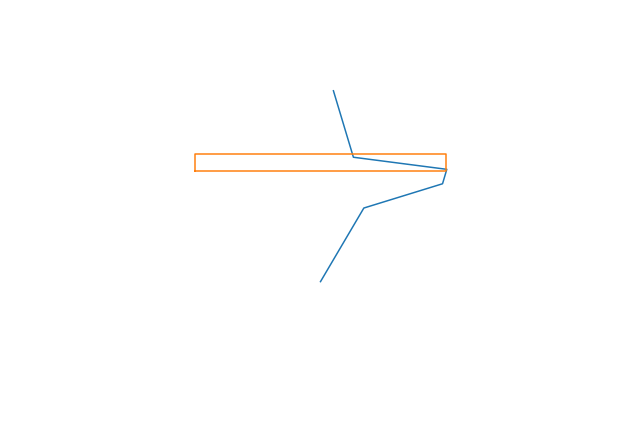

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


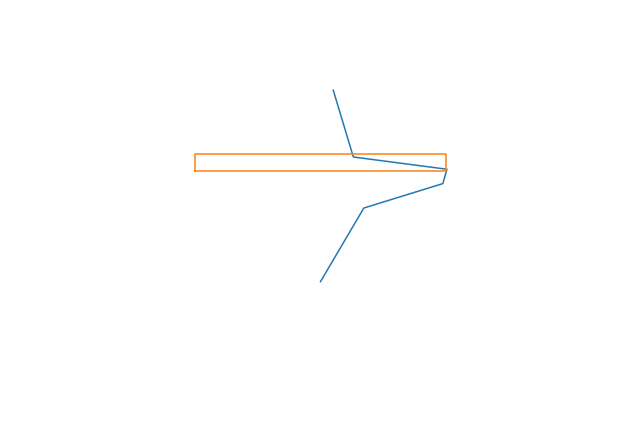

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


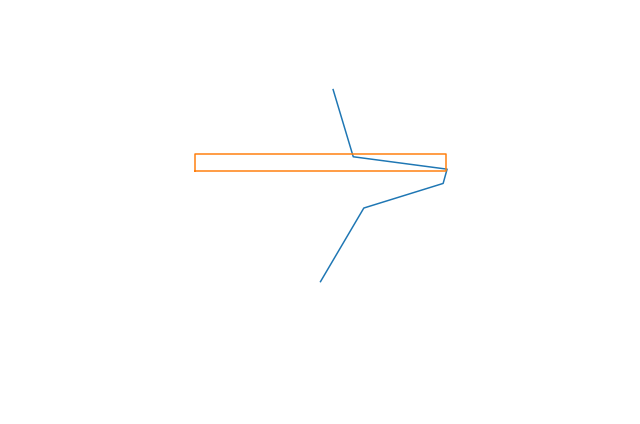

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


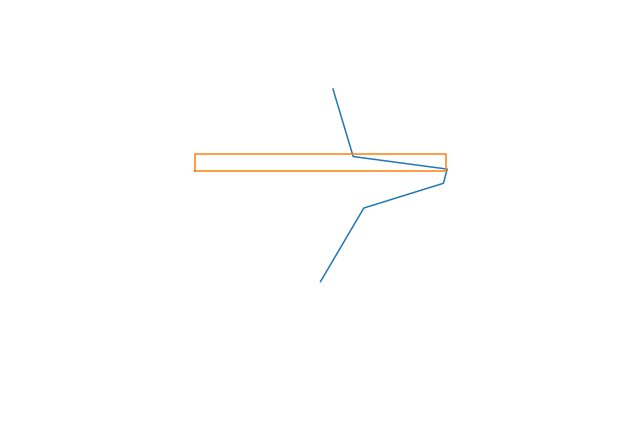

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


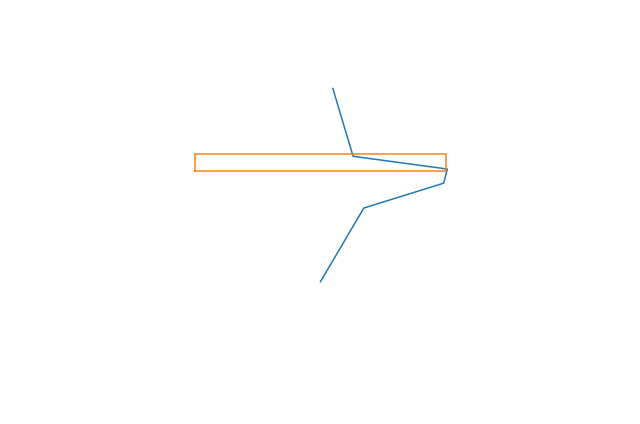

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


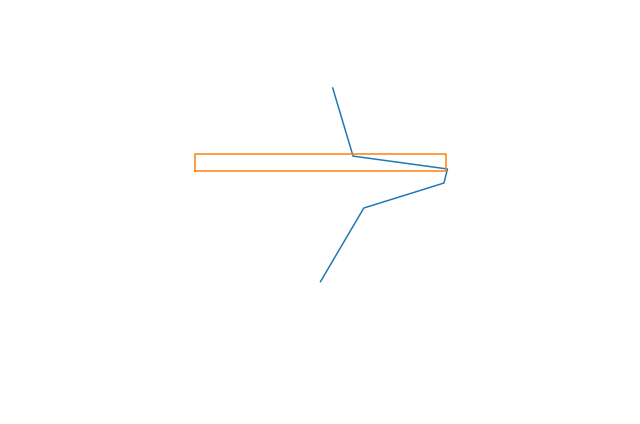

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


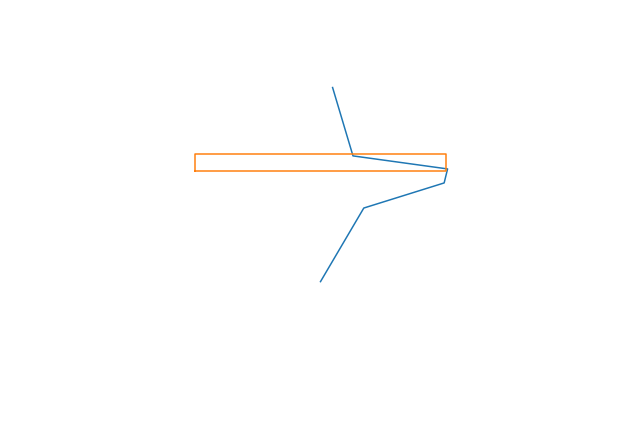

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


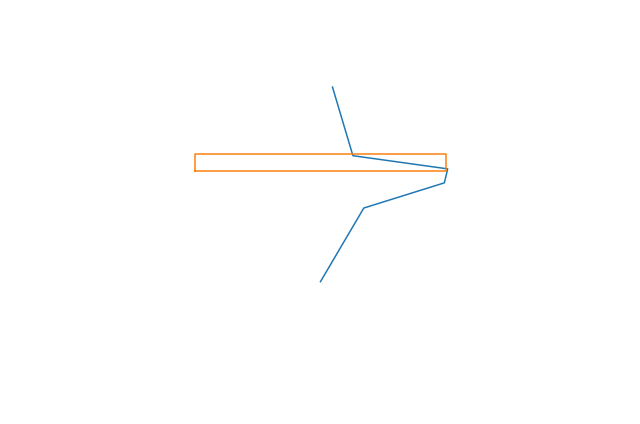

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


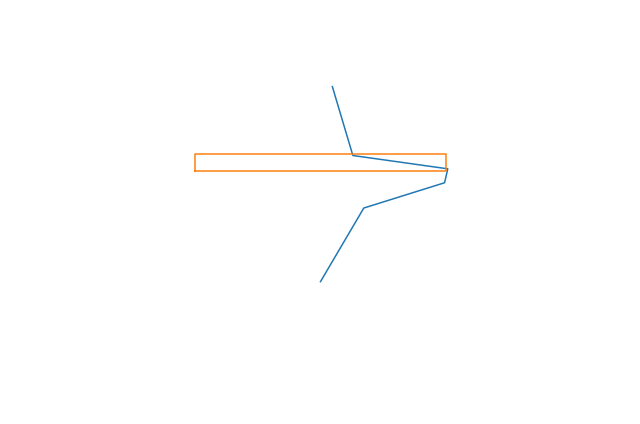

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


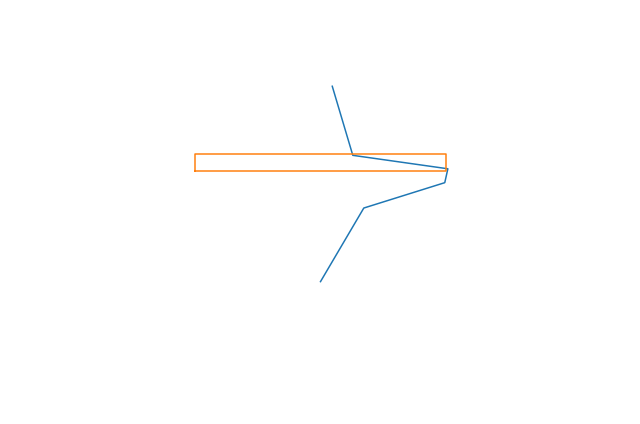

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


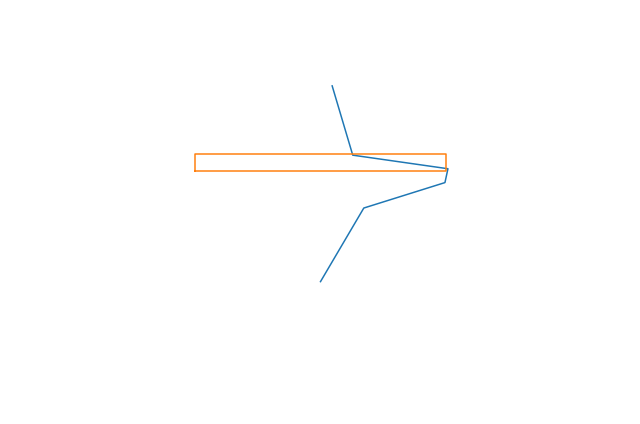

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


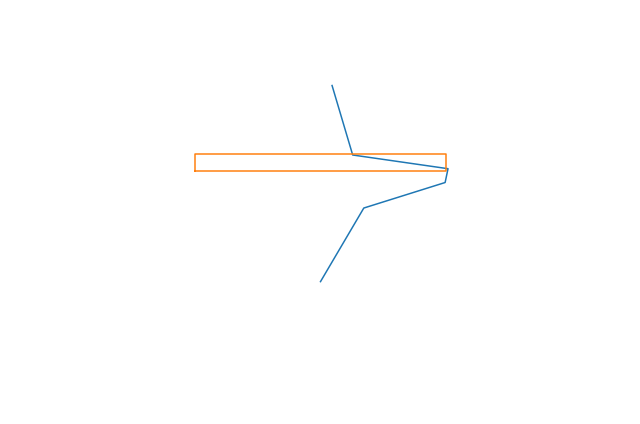

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


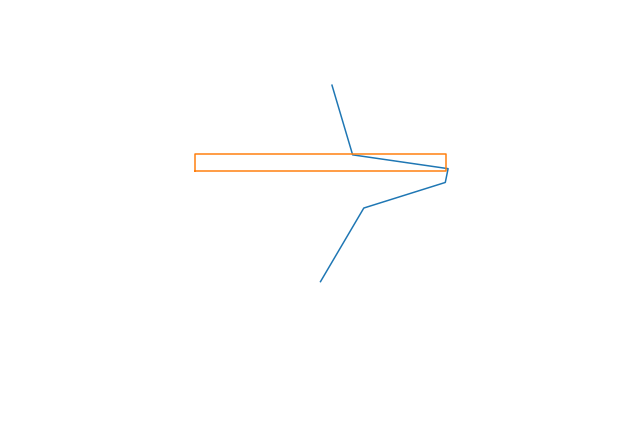

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


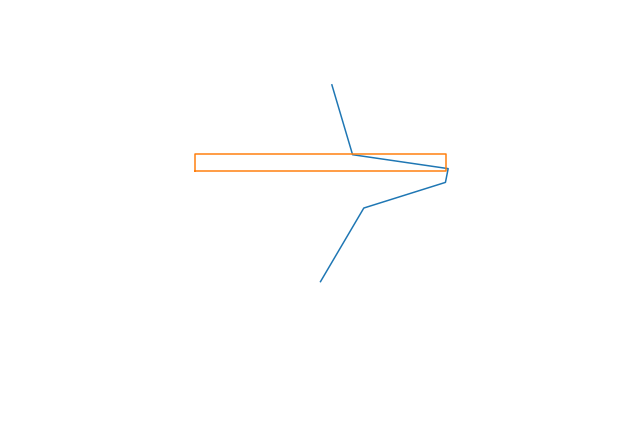

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


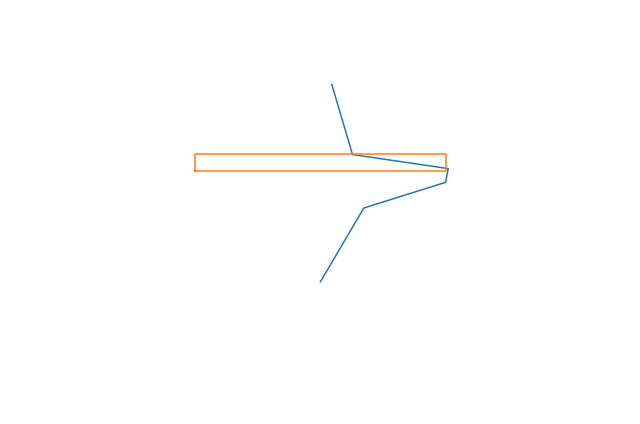

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


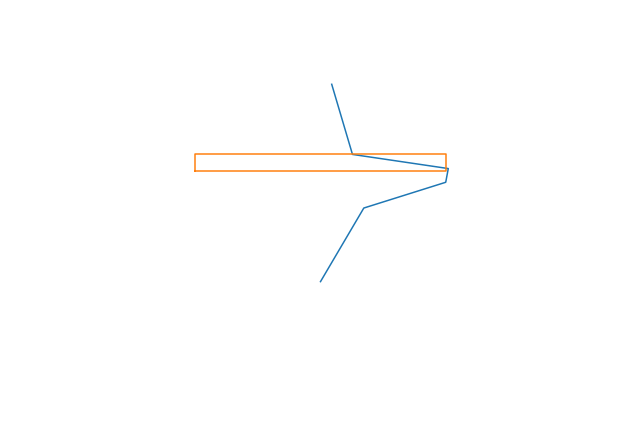

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


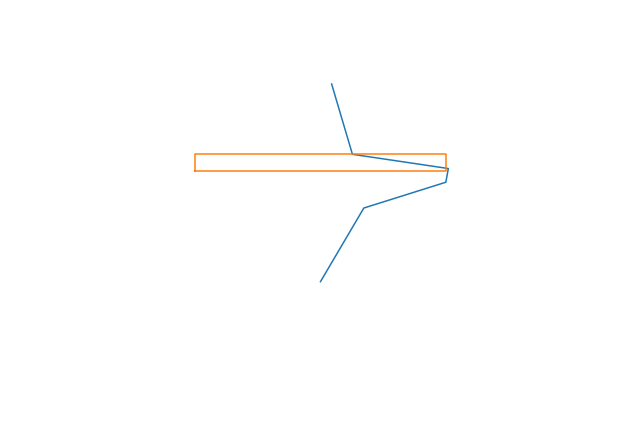

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


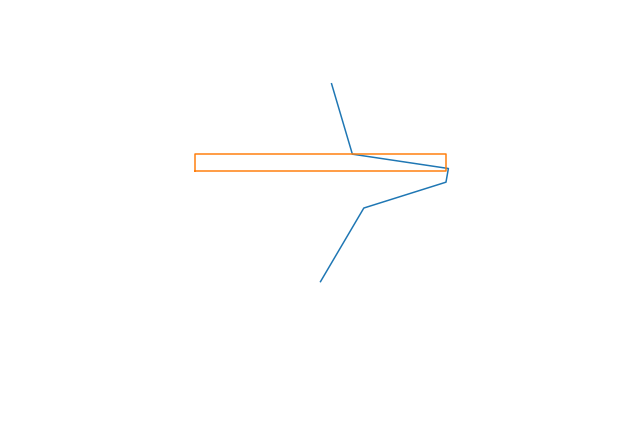

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


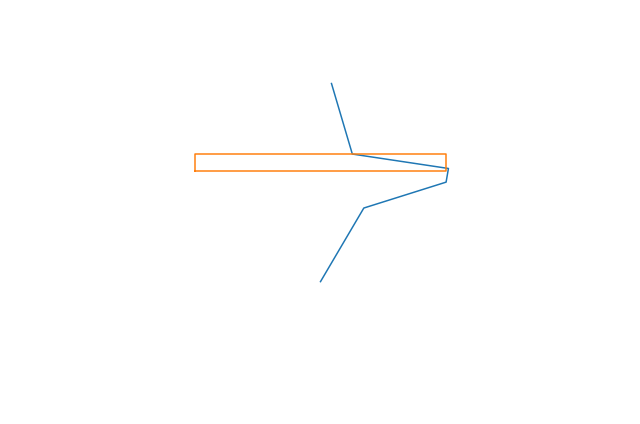

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


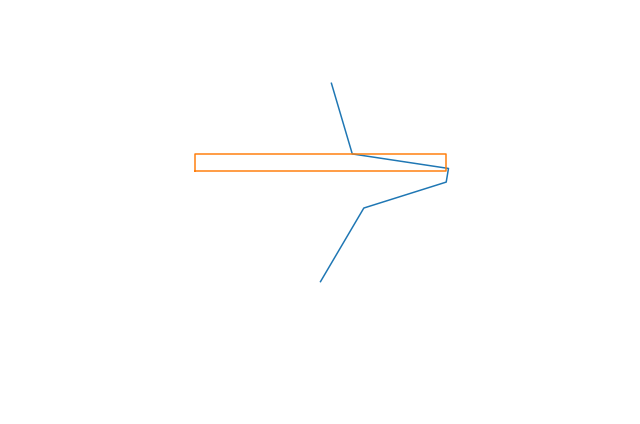

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


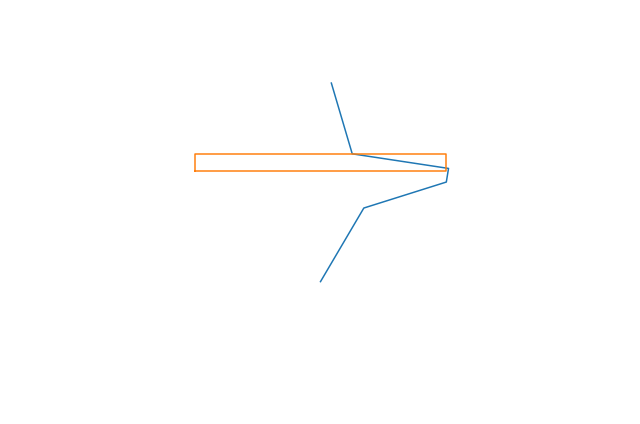

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


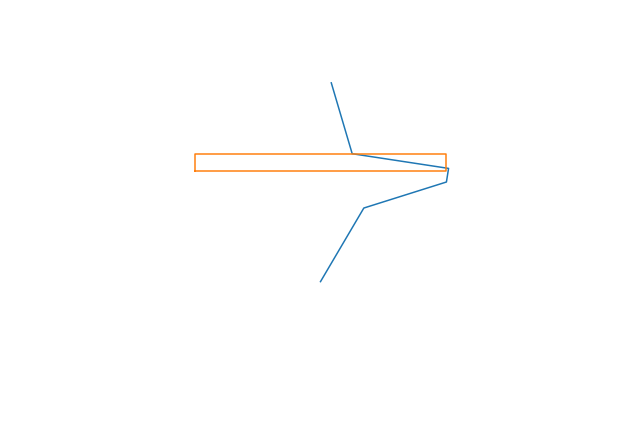

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


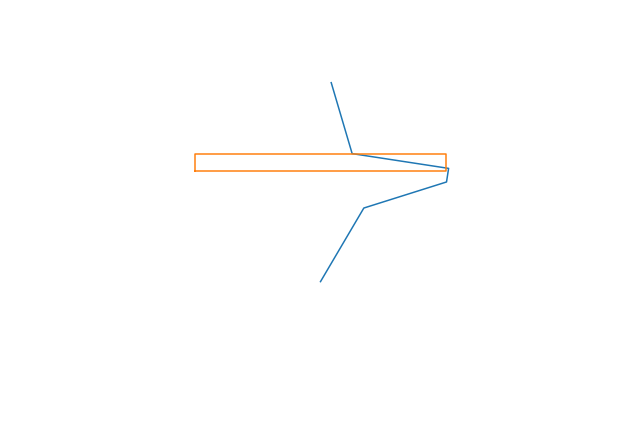

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


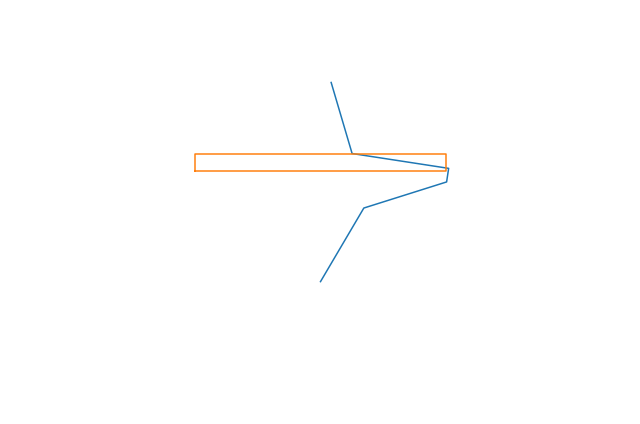

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


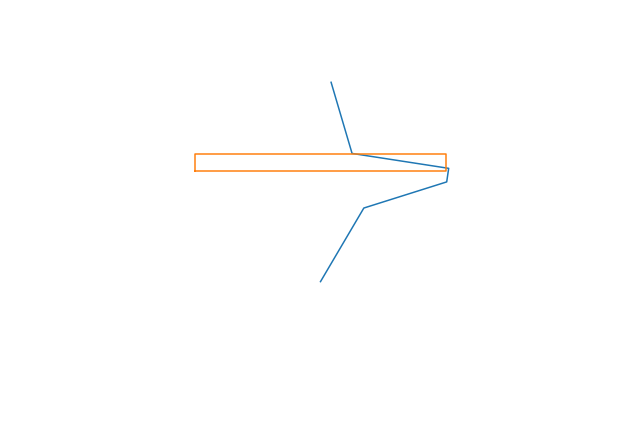

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


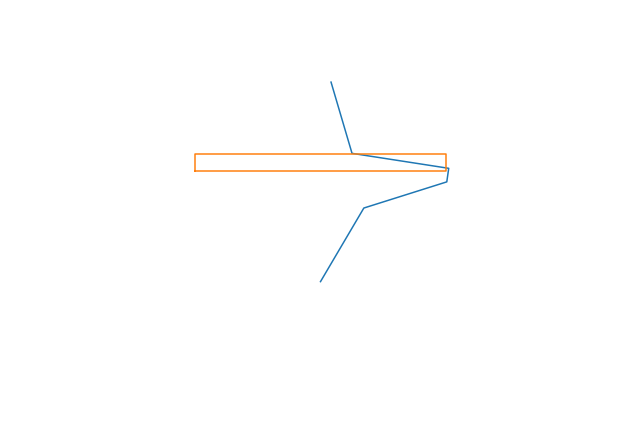

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


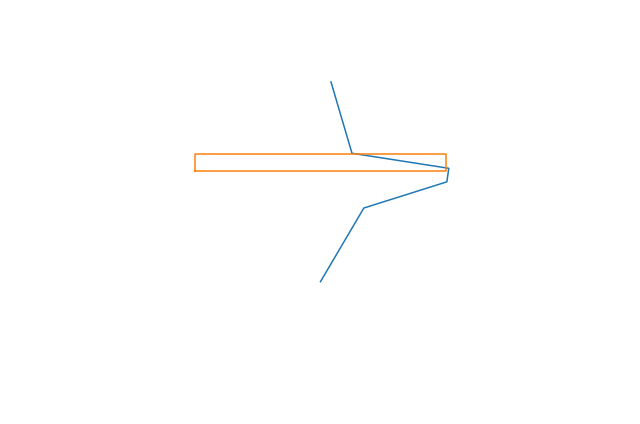

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


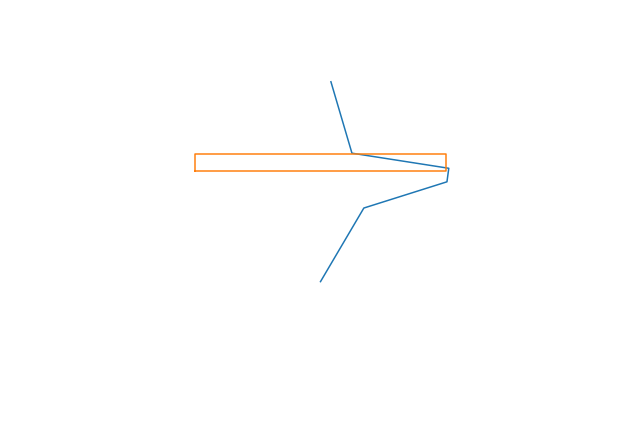

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


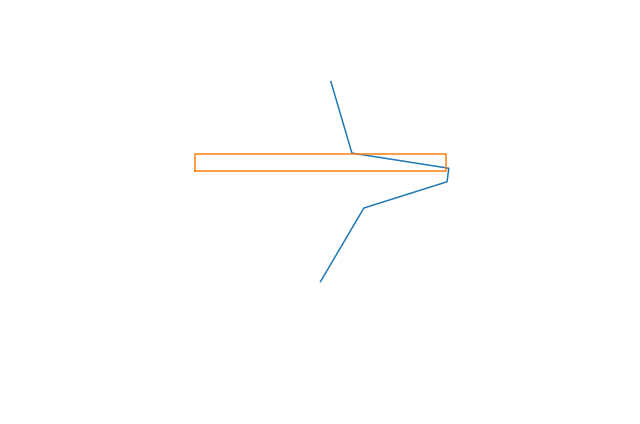

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


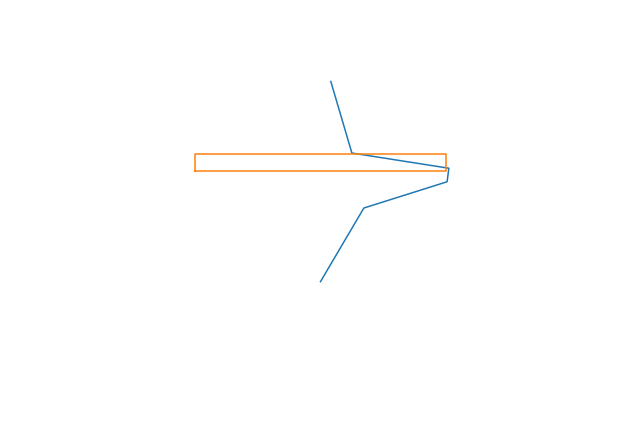

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


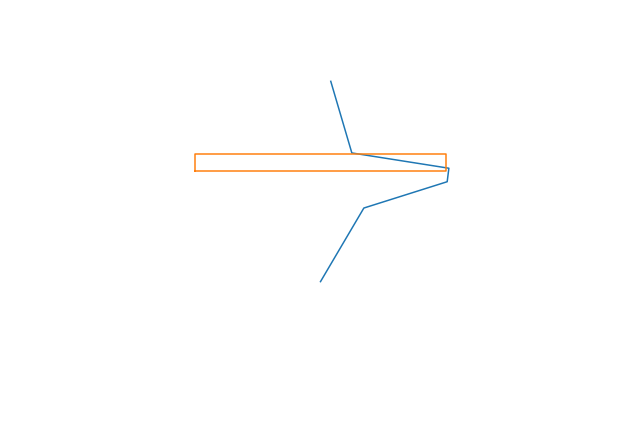

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


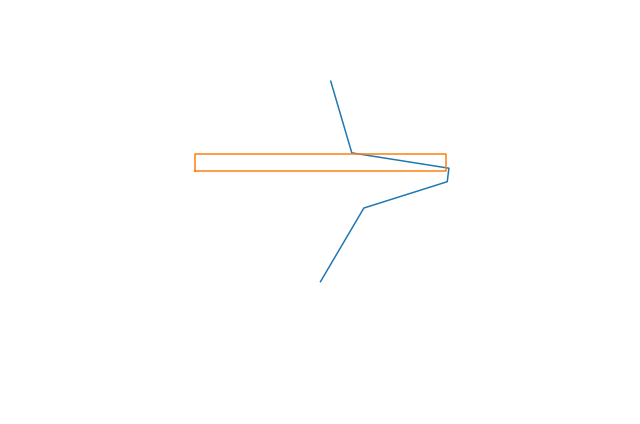

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


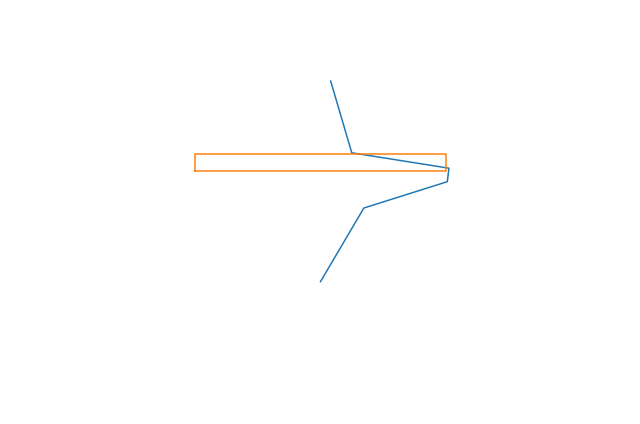

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


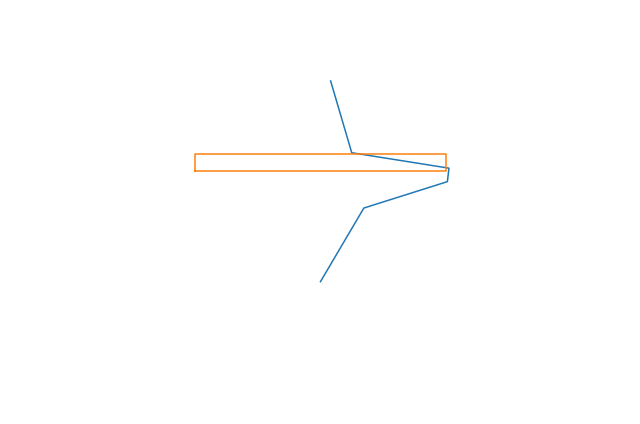

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


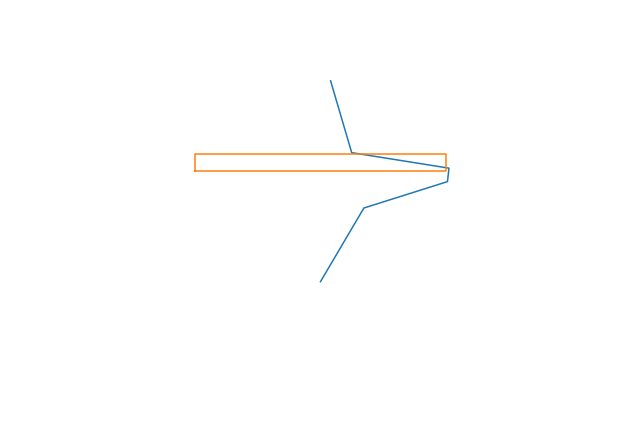

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


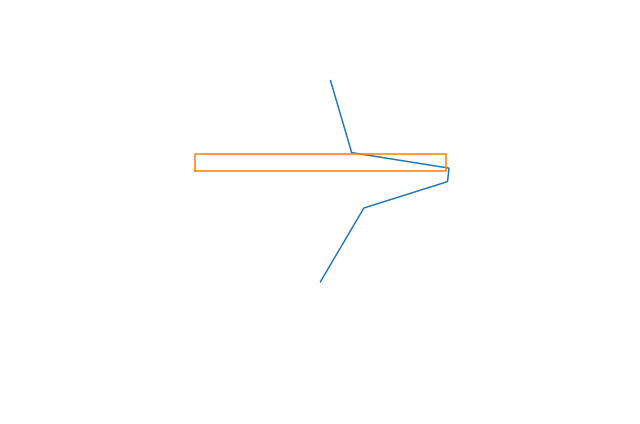

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


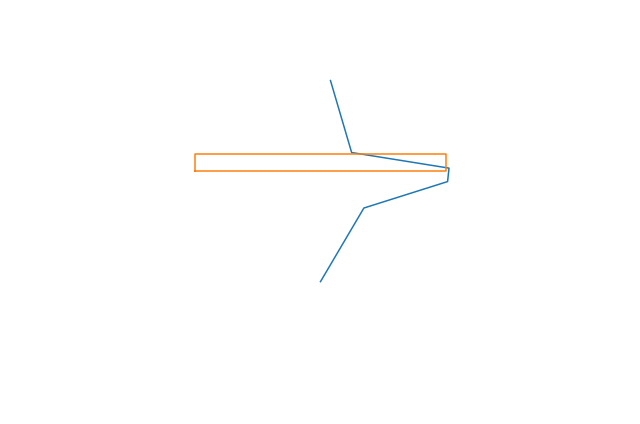

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


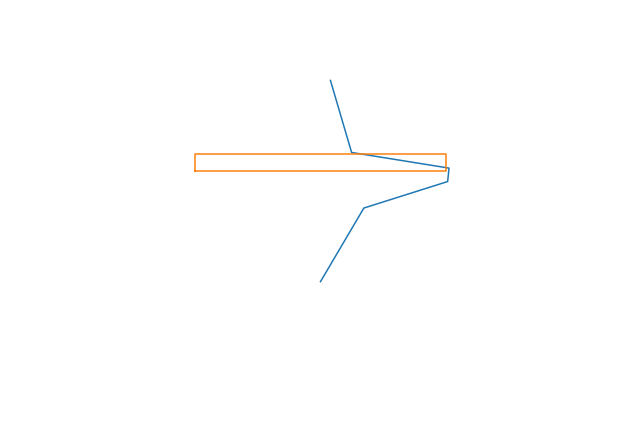

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


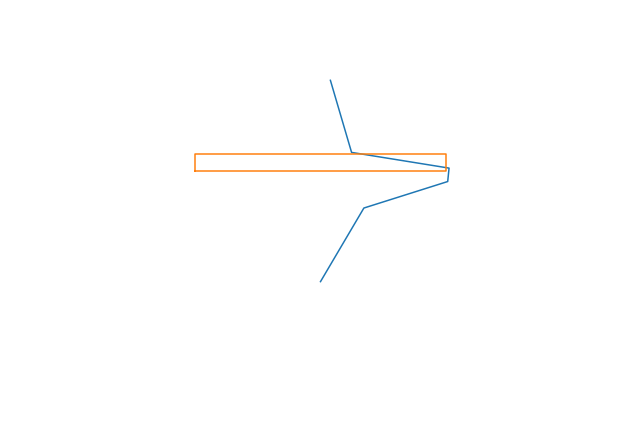

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


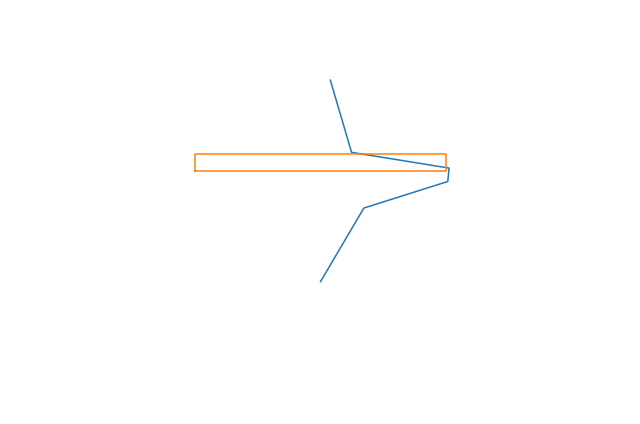

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


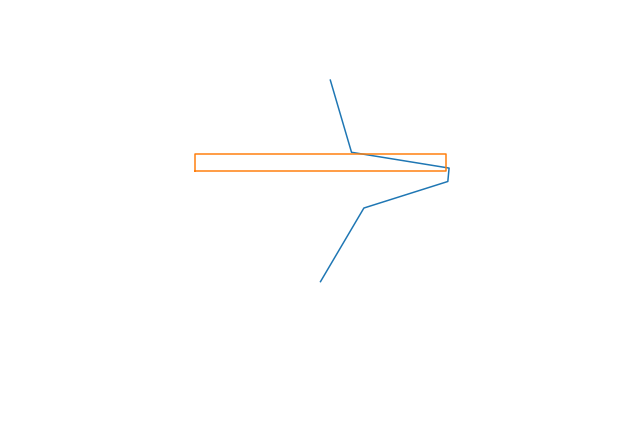

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


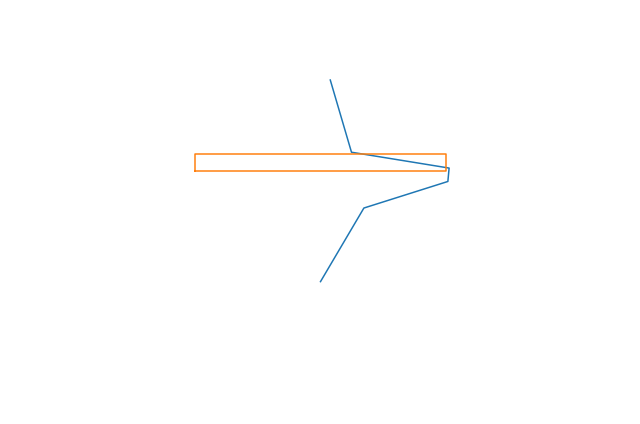

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


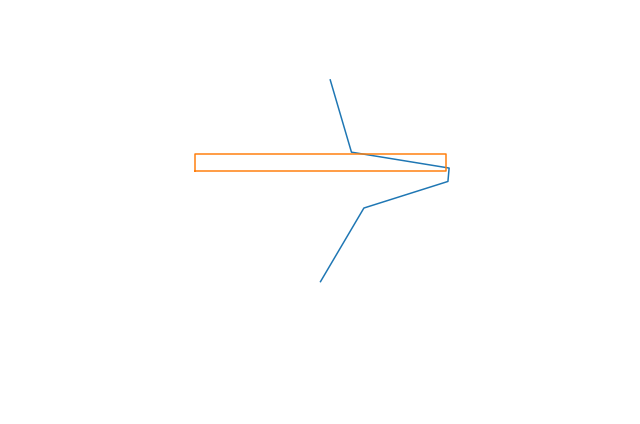

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


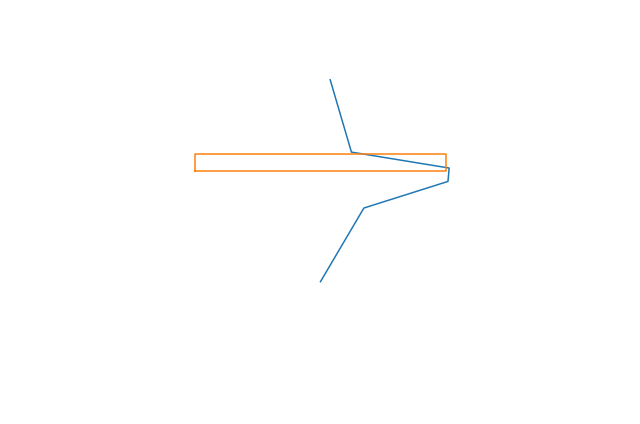

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


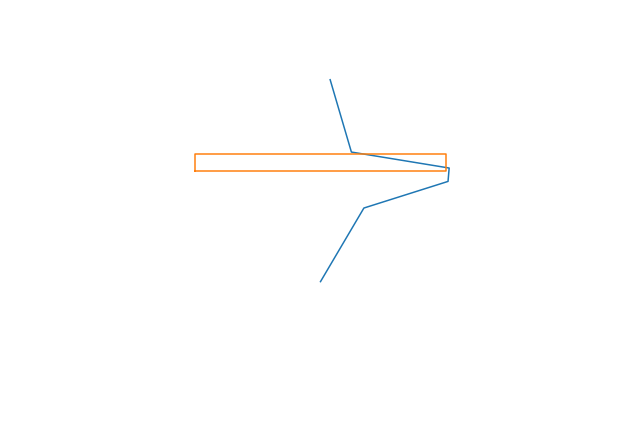

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


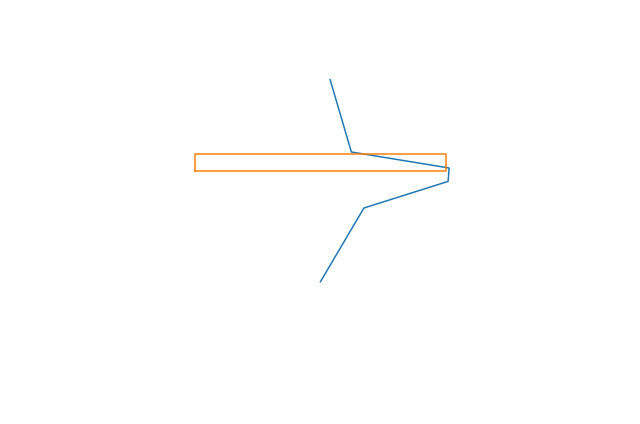

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [155]:
plt_imgs = []
for plan in plans[:100:10]:
    plan = plan[0, :6, :-2]
    states = agent._state(plan).mode()

    fig = plt.figure(figsize=(9,6))
    ax = plt.gca()
    plt.clf()  # Clear figure
#     plt.title('hi')
    plt.plot(states[:, 1], states[:, 0]) #, np.linspace(0, 1, states.shape[0]))
    x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
    plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])

    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
    # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.grid(False)
    plt.axis('off')
    # plt.grid(b=None)
    fig.tight_layout()
#     plt.savefig(config.logdir_colloc / f'visualization_{i}.jpg')
    plt.show()
    img = fig2img(fig)
    plt_imgs.append(img)
    
#     break



In [154]:
video = np.stack(plt_imgs, 0)
print(video.max(), video.shape)
# video = np.concatenate([video,np.flip(video, 0)])

skvideo.io.vwrite(config.logdir_colloc / 'result.mp4', video, inputdict={'-r': '10'})
skvideo.io.vwrite(config.logdir_colloc / 'result.gif', video, inputdict={'-r': '5'})
# HTML('<img src="result.gif">')

255 (100, 432, 648, 3)


In [380]:
# color = np.linspace(0, 1, 10)
# color
# plt.get_cmap()(1)
# np.save(config.logdir_colloc / 'good_plans_collocation.npy', plans)
plans = np.load(config.logdir_colloc / 'good_plans_collocation.npy')

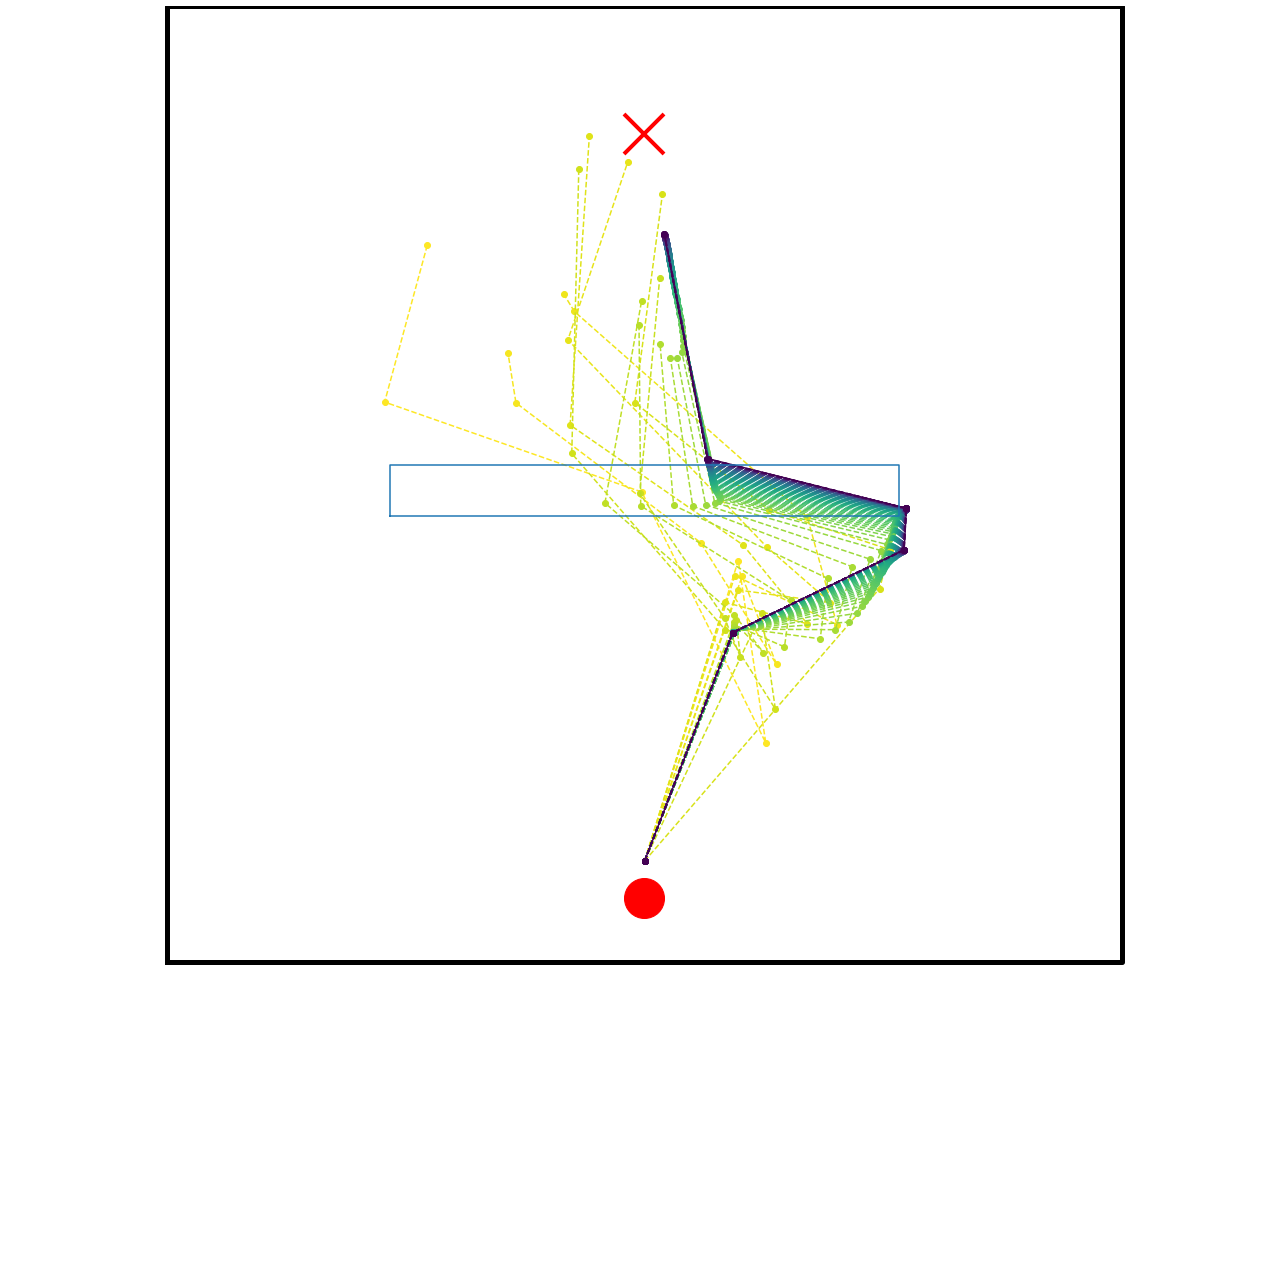

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [63]:
# Make collocation figure
plt_imgs = []
state_plans = []
for plan in plans[16:100]:
# for plan in plans[10:14]:
    plan = plan[0, :6, :-2]
    states = agent._state(plan).mode()
    state_plans.append(states)
    
    
    
fig = plt.figure(figsize=(18,18))
ax = plt.gca()
plt.clf()  # Clear figure
colors = np.linspace(1, 0, len(state_plans))

plt.plot([0], [-0.4], 'ro', ms=40)
plt.plot([0], [0.8], 'rx', mew=4, ms=40)
for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:, 1], states[:, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:, 1], state_plans[-1][:, 0], marker='o', color=cmap(colors[-1]))

x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])

x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.grid(False)
plt.axis('off')
fig.tight_layout()
plt.show()
img = fig2img(fig)
# imageio.imsave(config.logdir_colloc / 'visualization.jpg', img)

In [ ]:
# Plot shooting

# args = '--logdir /scratch/robotic_video/collocation/pm_obstacle/dreamer/ --task colloc_pm_obstacle --action_repeat 1 --time_limit 40 --planning_task shooting_cem --batch_length 30 --planning_horizon 40 --mpc_steps 40 --logdir_colloc ./logdir_colloc/pm_obstacle/09_29_denseoffline800k_40x1_cem200_-0.4_0 --cem_steps 200 --metrics_fix True --eval_tasks 5'
# config = parser.parse_args(args.split(' '))
# agent = DreamerColloc(config, datadir, actspace)
# agent.load(config.logdir / 'variables.pkl')

In [13]:
# Run shooting
# Define stuff
horizon = agent._c.planning_horizon
var_len = agent._actdim * agent._c.planning_horizon
batch = agent._c.cem_batch_size
init_feat, _ = agent.get_init_feat(obs)
elite_size = int(agent._c.cem_batch_size * agent._c.cem_elite_ratio)

# Sample
means = tf.zeros(var_len, dtype=agent._float)
stds = tf.ones(var_len, dtype=agent._float)
samples = tfd.MultivariateNormalDiag(means, stds).sample(sample_shape=[batch])
samples = tf.clip_by_value(samples, -1, 1)

# Evaluate
init_feats = tf.tile(init_feat, [batch, 1])
actions = tf.reshape(samples, [batch, horizon, -1])
feats = agent._dynamics.imagine_feat(actions, init_feats, deterministic=True)
fitness = tf.reduce_sum(agent._reward(feats).mode(), axis=1)
_, elite_inds = tf.nn.top_k(fitness, elite_size, sorted=False)
elite_samples = tf.gather(samples, elite_inds)
elite_plans = agent._state(feats).mode()
    
# Get elite states
# elite_samples.shape
# init_feats = tf.tile(init_feat, [100, 1])
# elite_feats = agent._dynamics.imagine_feat(tf.reshape(elite_samples, [100, horizon, -1]), init_feats, deterministic=True)
# elite_plans = agent._state(elite_feats).mode()

In [14]:
# elite_plans = [elite_plans.numpy() for plan in elite_plans]
# elite_plans = np.load(config.logdir_colloc / 'good_plans_collocation.npy')
np.save(config.logdir_colloc / 'good_plans_shooting.npy', elite_plans)

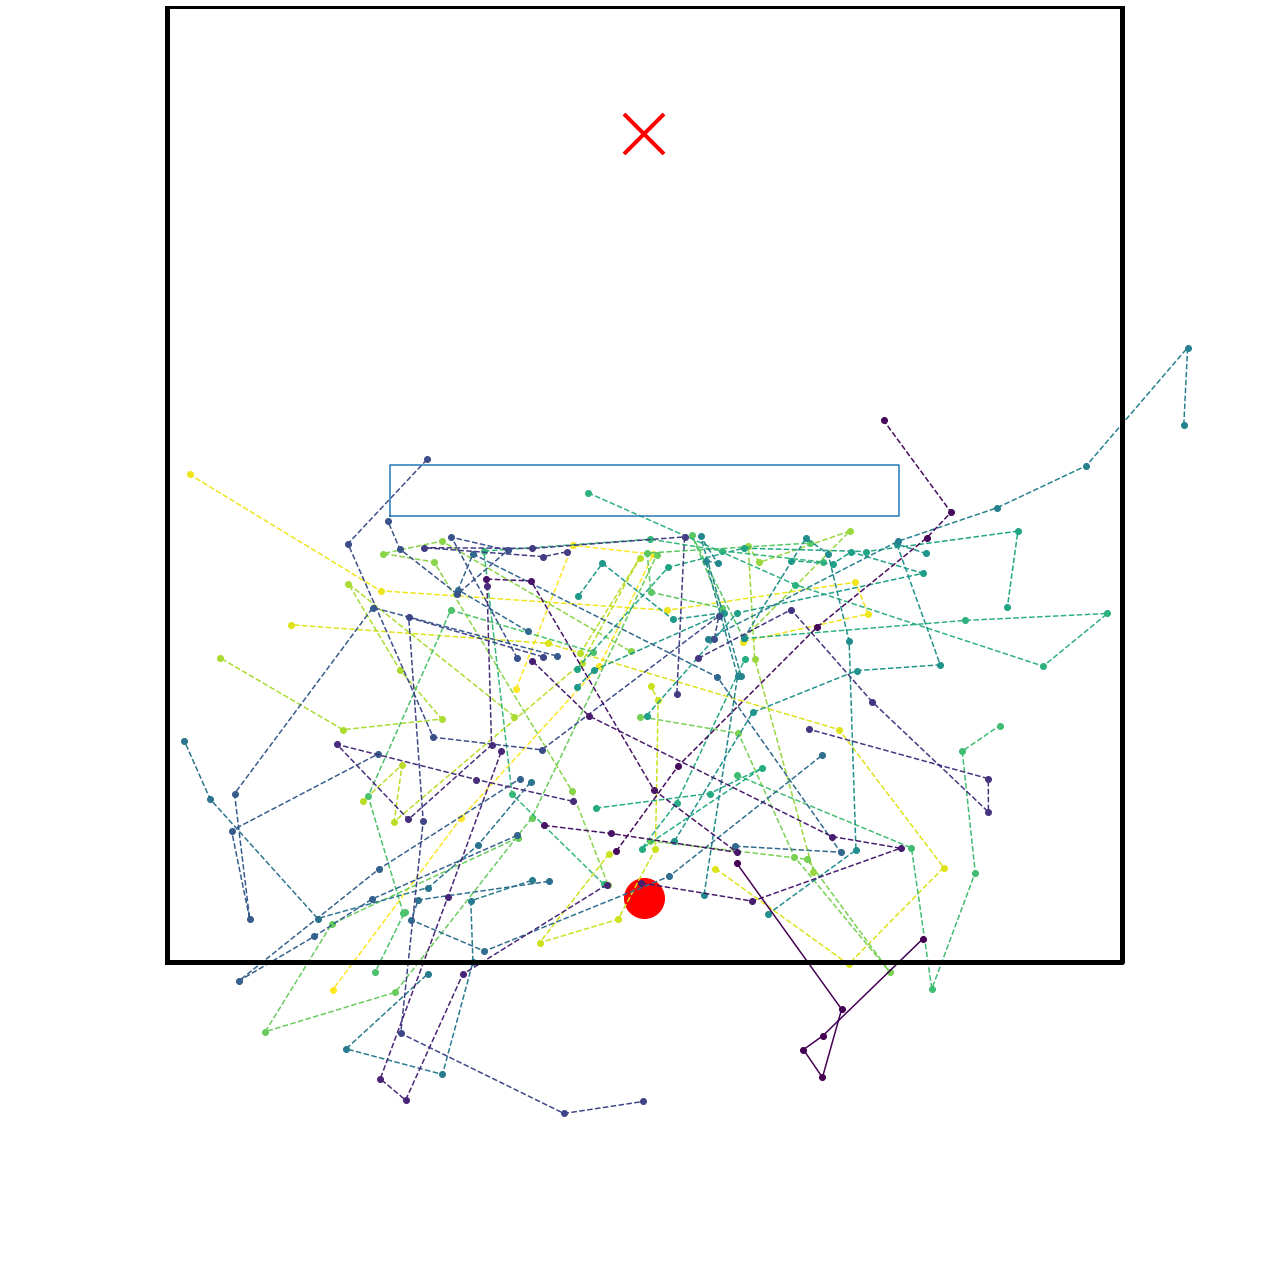

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [60]:
elite_plans = np.load(config.logdir_colloc / 'good_plans_shooting.npy')
# Make collocation figure
state_plans = []
for plan in elite_plans[40:80]:
# for plan in plans[10:14]:
    plan = plan[:6, :-2]
    state_plans.append(plan)
    
    
fig = plt.figure(figsize=(18,18))
ax = plt.gca()
plt.clf()  # Clear figure
colors = np.linspace(1, 0, len(state_plans))
cmap = plt.get_cmap()

plt.plot([0], [-0.4], 'ro', ms=40)
plt.plot([0], [0.8], 'rx', mew=4, ms=40)
for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:, 1], states[:, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:, 1], state_plans[-1][:, 0], marker='o', color=cmap(colors[-1]))

x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])

x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.grid(False)
plt.axis('off')
fig.tight_layout()
plt.show()
img = fig2img(fig)
# imageio.imsave(config.logdir_colloc / 'visualization_shoot.jpg', img)

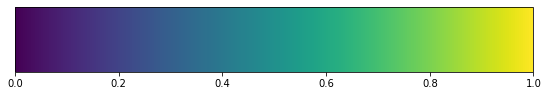

In [56]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("colorbar.pdf")